# Continous Assessment - 1

The figures for 2017 - 2022 have been revised following a detailed analysis of the Census 2022. People from households that were temporarily absent outside Ireland on Census night are included in the 2022 data for the first time. This impacts additivity of population change components between 2021 and 2022.
Figures for immigration and emigration are not available prior to 1987.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, binom
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('annual_population_change_updated.csv')
df.head()

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02541V03076,Component,UNIT,VALUE
0,PEA15,Annual Population Change,1951,1951,1,Annual births,Thousand,NaN
1,PEA15,Annual Population Change,1951,1951,2,Annual deaths,Thousand,NaN
2,PEA15,Annual Population Change,1951,1951,3,Natural increase,Thousand,26.6
3,PEA15,Annual Population Change,1951,1951,4,Immigrants,Thousand,NaN
4,PEA15,Annual Population Change,1951,1951,5,Emigrants,Thousand,NaN


In [3]:
df.shape

(584, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATISTIC        584 non-null    object 
 1   STATISTIC Label  584 non-null    object 
 2   TLIST(A1)        584 non-null    int64  
 3   Year             584 non-null    int64  
 4   C02541V03076     584 non-null    int64  
 5   Component        584 non-null    object 
 6   UNIT             584 non-null    object 
 7   VALUE            440 non-null    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 36.6+ KB


In the dataset, object data types are present in four variables, integer data types in three, and float data types in one.

In [5]:
# count of null values
null_counts = df.isnull().sum()
print('Column Name: \t Null Value Count')
print(null_counts)

Column Name: 	 Null Value Count
STATISTIC            0
STATISTIC Label      0
TLIST(A1)            0
Year                 0
C02541V03076         0
Component            0
UNIT                 0
VALUE              144
dtype: int64


In [6]:
# unique components and components with the null values
unique_components = df['Component'].unique()
print('Unique labels of Component variable')
print(unique_components,'\n')
null_value_components = df[df.isnull().any(axis=1)].Component.unique()
print("Labels that have null values")
print(null_value_components)

Unique labels of Component variable
['Annual births' 'Annual deaths' 'Natural increase' 'Immigrants'
 'Emigrants' 'Net migration' 'Population change' 'Population'] 

Labels that have null values
['Annual births' 'Annual deaths' 'Immigrants' 'Emigrants']


- All  columns have 584 values, except for the Value column which has 144 values missing.
- This element has 8 unique values "'Annual Births', 'Annual Deaths', 'Natural Growth', 'Immigrants', 'Migrants', 'Net Migration', ' Population change', 'Population'". 
- Among these labels "'Births annually', 'Deaths every year', 'Immigrants', 'Emigrants'", these labels contain missing values from 1951 to 1986 and the labels the rest have value.
- The reason for the missing value cannot be determined because the dataset was taken from an available CSO website.
- If we remove missing values then we have to delete rows with values and here data loss will occur which is not good for  machine learning model.

In [7]:
# Dropping columns
columns_to_drop = ['STATISTIC','STATISTIC Label','TLIST(A1)','C02541V03076','UNIT']
df = df.drop(columns = columns_to_drop)

## Columns to be dropped

- "STATISTIC" and "STATISTIC Label" are only variables of the datasets; neither one contains any information about the dataset. As a result, both columns have been removed.

- The information in "TLIST(A1)" is identical to that in the "Year" column, making it a redundant column. The duplicate column has been eliminated as a result.

- The "Component" column and the column "C02541V03076" both encode the same data. In essence, it serves as the component variable's label. As a result, this column has been removed.

- The values in the "Value" column are expressed as thousands of units, as indicated by the "UNIT" column. Going forwared it will be assumed that all the values will be measured in Thousands. Hence removed the column


In [8]:
# updated dataframe
df.head()

,Year,Component,VALUE
0,1951,Annual births,NaN
1,1951,Annual deaths,NaN
2,1951,Natural increase,26.6
3,1951,Immigrants,NaN
4,1951,Emigrants,NaN


In [9]:
# creating a pivot table with the components unique labels
pivoted_df = pd.pivot_table(df, index = 'Year', columns = 'Component', values = 'VALUE')

In [10]:
df_new = pivoted_df.reset_index()

In [11]:
df_new.head()

Component,Year,Annual births,Annual deaths,Emigrants,Immigrants,Natural increase,Net migration,Population,Population change
0,1951,NaN,NaN,NaN,NaN,26.6,-35.0,2960.6,-8.4
1,1952,NaN,NaN,NaN,NaN,27.3,-35.0,2952.9,-7.7
2,1953,NaN,NaN,NaN,NaN,29.1,-33.0,2949.0,-3.9
3,1954,NaN,NaN,NaN,NaN,28.2,-36.0,2941.2,-7.8
4,1955,NaN,NaN,NaN,NaN,24.7,-45.0,2920.9,-20.3


In [12]:
df_new.shape

(73, 9)

In [13]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               73 non-null     int64  
 1   Annual births      37 non-null     float64
 2   Annual deaths      37 non-null     float64
 3   Emigrants          37 non-null     float64
 4   Immigrants         37 non-null     float64
 5   Natural increase   73 non-null     float64
 6   Net migration      73 non-null     float64
 7   Population         73 non-null     float64
 8   Population change  73 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 5.3 KB


In [14]:
df_new.describe()

Component,Year,Annual births,Annual deaths,Emigrants,Immigrants,Natural increase,Net migration,Population,Population change
count,73.000000,37.000000,37.000000,37.000000,37.000000,73.000000,73.000000,73.000000,73.000000
mean,1987.000000,60.105405,30.651351,48.459459,65.405405,30.260274,1.078082,3650.532877,31.339726
std,21.217131,8.080462,1.975070,18.520371,32.716840,7.447385,32.866465,719.507144,34.295115
min,1951.000000,48.400000,27.000000,25.300000,17.200000,16.600000,-58.000000,2818.300000,-32.600000
25%,1969.000000,53.600000,28.900000,31.500000,40.700000,25.600000,-22.900000,2952.900000,11.800000
50%,1987.000000,59.700000,31.000000,49.200000,59.000000,29.100000,-2.000000,3529.000000,25.000000
75%,2005.000000,65.400000,32.000000,64.000000,84.600000,34.900000,17.400000,4133.800000,50.600000
max,2023.000000,77.200000,35.500000,83.000000,151.100000,48.800000,104.800000,5281.600000,142.900000


In [15]:
df_new.isnull().sum()

Component
Year                  0
Annual births        36
Annual deaths        36
Emigrants            36
Immigrants           36
Natural increase      0
Net migration         0
Population            0
Population change     0
dtype: int64

- As highlighted above, there are 144 missing values in the Annual Births, Annual Deaths, Emigrants, and Immigrants columns from 1951 to 1986.
- After  the pivot table is created, the appearance of the database has changed from (584,8) to (73,9).
- If we choose to leave the values as is and assign a value of 0 in place of the  missing values, there will be no change in the set data and  distribution will not change.
- And if we choose to remove zero values, almost half of the dataset will be removed because the missing values in the new rotated dataset account for almost half of the total values, this is not a method nice.
- So just create two separate data frames and analyze the impact that adding zeros to the  overall data and machine learning model or removing zero values will have on the  machine learning model.

In [16]:
df_na_filled = df_new.fillna(0)

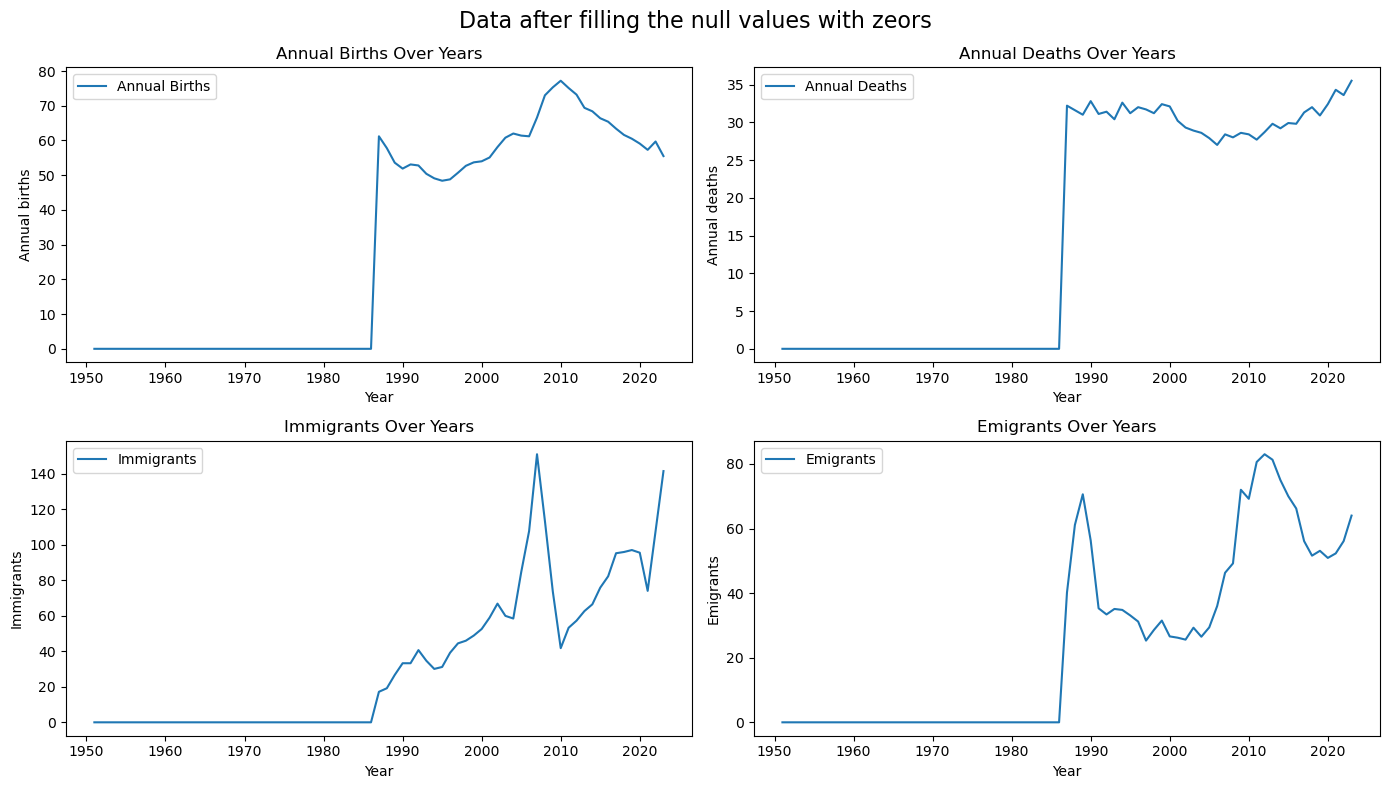

In [17]:
# Plot before handling null values i.e filling the values with zeros
plt.figure(figsize=(14, 8))
plt.suptitle('Data after filling the null values with zeors', fontsize=16)

plt.subplot(2, 2, 1)
sns.lineplot(x='Year', y='Annual births', data=df_na_filled, label='Annual Births')
plt.title('Annual Births Over Years')

plt.subplot(2, 2, 2)
sns.lineplot(x='Year', y='Annual deaths', data=df_na_filled, label='Annual Deaths')
plt.title('Annual Deaths Over Years')

plt.subplot(2, 2, 3)
sns.lineplot(x='Year', y='Immigrants', data=df_na_filled, label='Immigrants')
plt.title('Immigrants Over Years')

plt.subplot(2, 2, 4)
sns.lineplot(x='Year', y='Emigrants', data=df_na_filled, label='Emigrants')
plt.title('Emigrants Over Years')

plt.savefig('Zero_null_values_plot.png')
plt.tight_layout()
plt.show()


The  spike in the chart after 1986 when replacing null values with zeros significantly affecting the mean or total price treatment in the following years. This will impact the summary statistics and calculations associated with these columns, causing spikes in the visualization . One way to handle this problem is by replacing the zero value with more meaningful values, such as the mean or median of the respective columns. But the estimated values will be closer to the existing data distribution, which can lead to a smoother visualization transition. We can replace zero values with the average value of each column before plotting, which can provide a  continuous display and is easier to understand.

In [18]:
df_imputed = df_new.copy()

In [19]:
df_imputed[null_value_components] = df_imputed[null_value_components].fillna(df_imputed[null_value_components].mean())

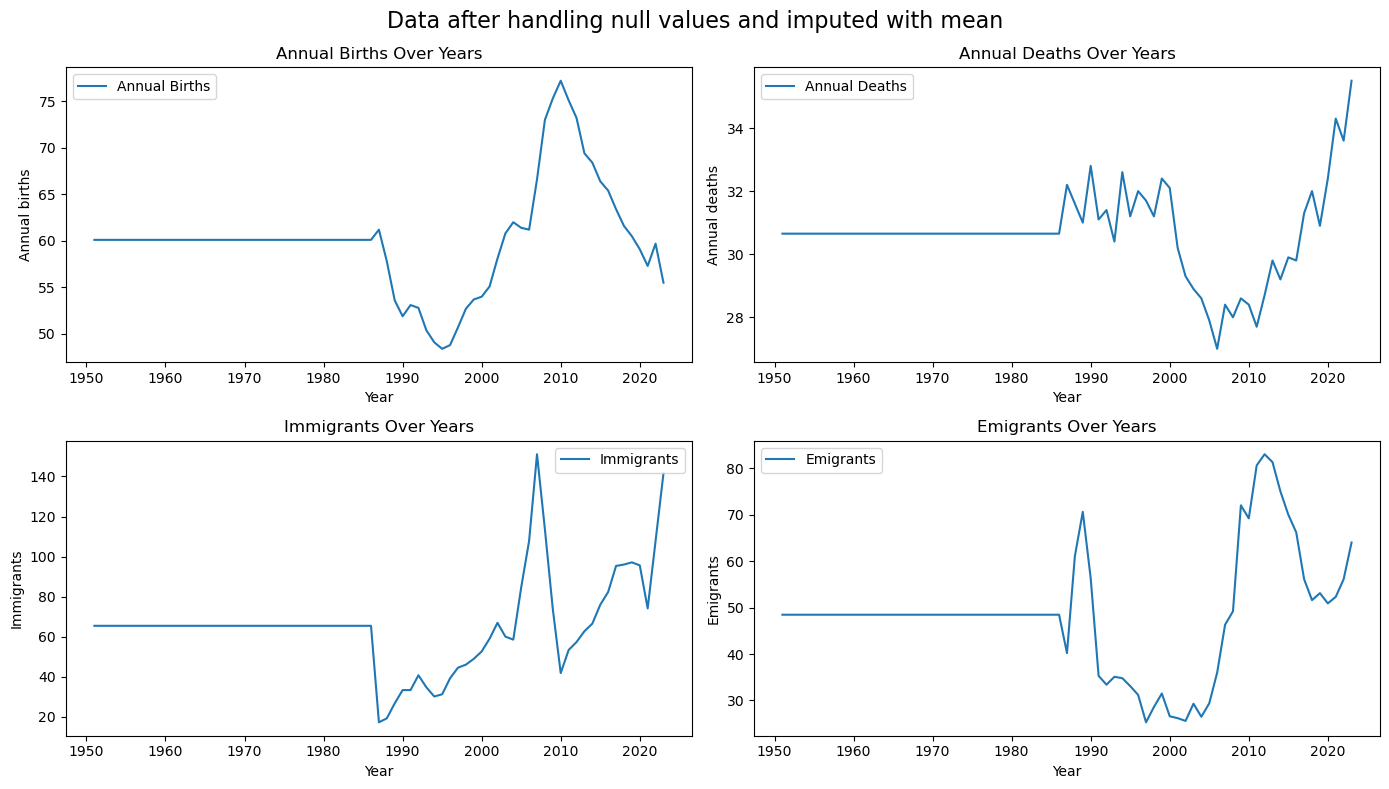

In [20]:
# Plot after handling null values and filling it with mean values
plt.figure(figsize=(14, 8))
plt.suptitle('Data after handling null values and imputed with mean', fontsize=16)

plt.subplot(2, 2, 1)
sns.lineplot(x='Year', y='Annual births', data=df_imputed, label='Annual Births')
plt.title('Annual Births Over Years')

plt.subplot(2, 2, 2)
sns.lineplot(x='Year', y='Annual deaths', data=df_imputed, label='Annual Deaths')
plt.title('Annual Deaths Over Years')

plt.subplot(2, 2, 3)
sns.lineplot(x='Year', y='Immigrants', data=df_imputed, label='Immigrants')
plt.title('Immigrants Over Years')

plt.subplot(2, 2, 4)
sns.lineplot(x='Year', y='Emigrants', data=df_imputed, label='Emigrants')
plt.title('Emigrants Over Years')

plt.savefig('mean_null_values_plot.png')
plt.tight_layout()
plt.show()


In [21]:
df_dropped_na = df_new.dropna().reset_index()

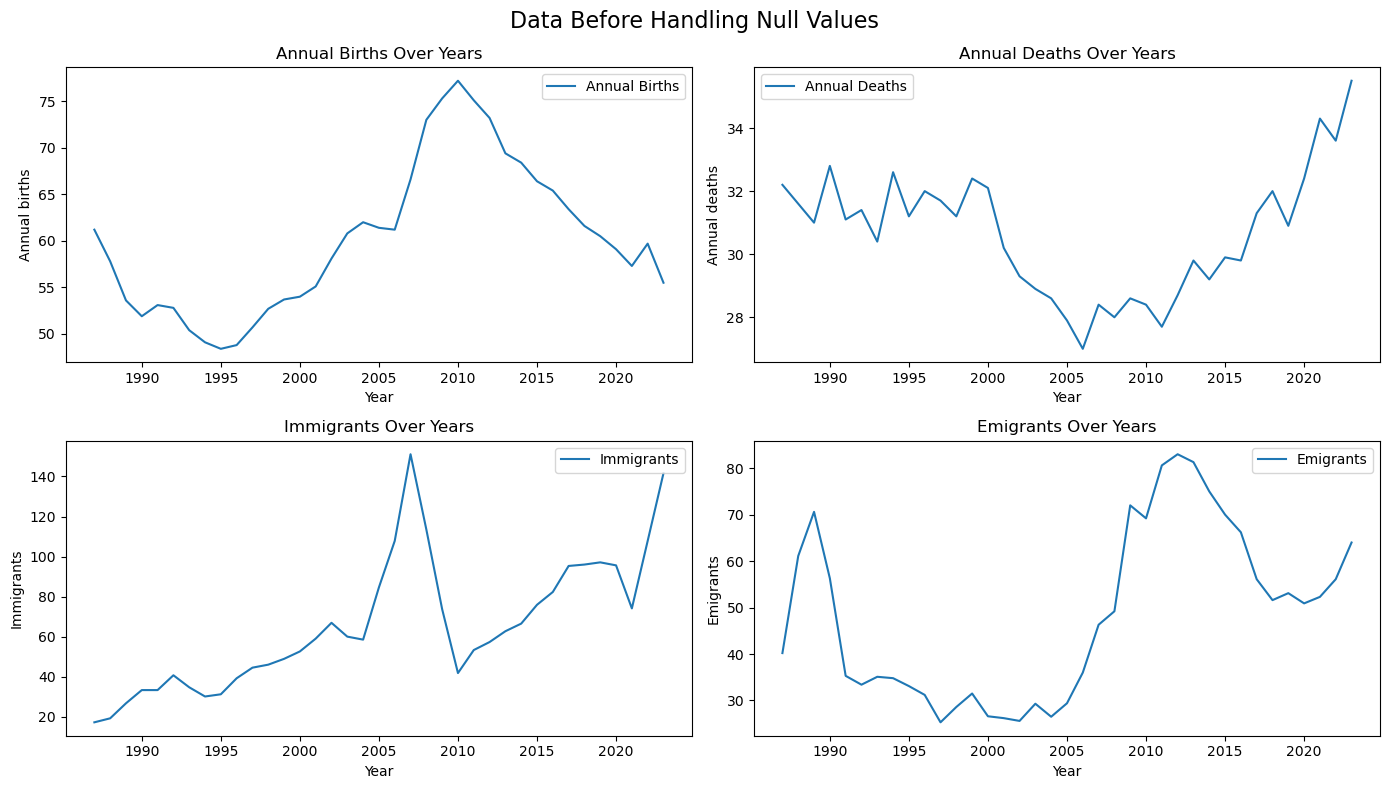

In [22]:
# Plot after dropping the null values handling null values
plt.figure(figsize=(14, 8))
plt.suptitle('Data Before Handling Null Values', fontsize=16)

plt.subplot(2, 2, 1)
sns.lineplot(x='Year', y='Annual births', data=df_dropped_na, label='Annual Births')
plt.title('Annual Births Over Years')

plt.subplot(2, 2, 2)
sns.lineplot(x='Year', y='Annual deaths', data=df_dropped_na, label='Annual Deaths')
plt.title('Annual Deaths Over Years')

plt.subplot(2, 2, 3)
sns.lineplot(x='Year', y='Immigrants', data=df_dropped_na, label='Immigrants')
plt.title('Immigrants Over Years')

plt.subplot(2, 2, 4)
sns.lineplot(x='Year', y='Emigrants', data=df_dropped_na, label='Emigrants')
plt.title('Emigrants Over Years')

plt.savefig('null_values_dropped_plot.png')
plt.tight_layout()
plt.show()


The decision to drop or impute missing values is based on a careful consideration of the nature of the missing data and its potential impact on the analysis. By dropping the missing data, we came to know that it leads to a substantial data loss and introduces bias. Therefore alternative strategies like imputation(like mean) is explored.

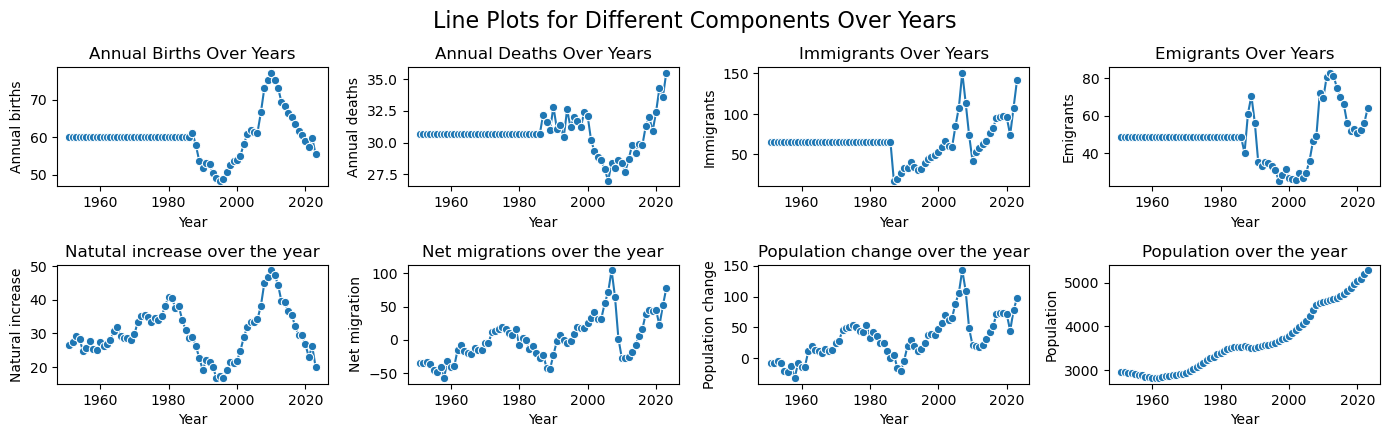

In [23]:
# Analysing different components over the years 
plt.figure(figsize=(14, 8))
plt.suptitle('Line Plots for Different Components Over Years', fontsize=16)

plt.subplot(4, 4, 1)
sns.lineplot(x='Year', y='Annual births', data=df_imputed, marker='o')
plt.title('Annual Births Over Years')

plt.subplot(4, 4, 2)
sns.lineplot(x='Year', y='Annual deaths', data=df_imputed, marker='o')
plt.title('Annual Deaths Over Years')

plt.subplot(4, 4, 3)
sns.lineplot(x='Year', y='Immigrants', data=df_imputed, marker='o')
plt.title('Immigrants Over Years')

plt.subplot(4, 4, 4)
sns.lineplot(x='Year', y='Emigrants', data=df_imputed, marker='o')
plt.title('Emigrants Over Years')

plt.subplot(4, 4, 5)
sns.lineplot(x = 'Year', y='Natural increase', data = df_imputed, marker = 'o')
plt.title('Natutal increase over the year')

plt.subplot(4, 4, 6)
sns.lineplot(x = 'Year', y='Net migration', data = df_imputed, marker = 'o')
plt.title('Net migrations over the year')

plt.subplot(4, 4, 7)
sns.lineplot(x = 'Year', y='Population change', data = df_imputed, marker = 'o')
plt.title('Population change over the year')

plt.subplot(4, 4, 8)
sns.lineplot(x = 'Year', y='Population', data = df_imputed, marker = 'o')
plt.title('Population over the year')

plt.savefig('Components_over_the_years.png')
plt.tight_layout()
plt.show()


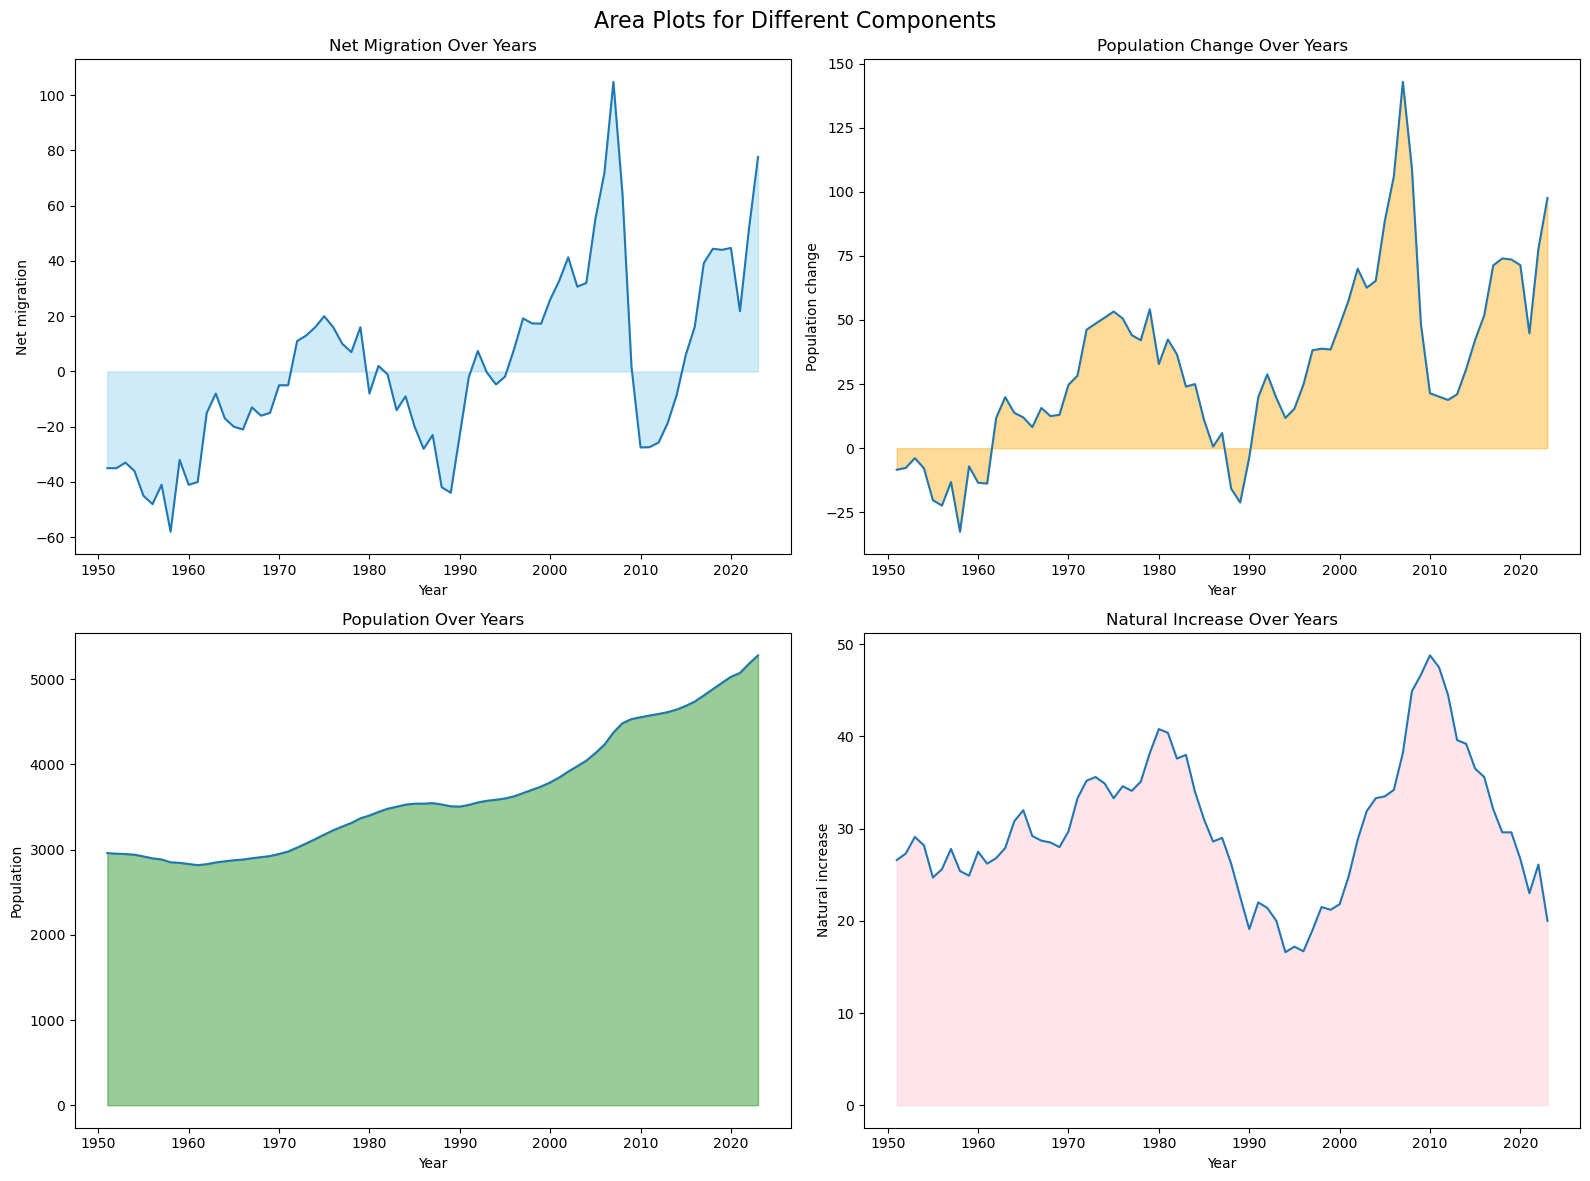

In [24]:
plt.figure(figsize=(16, 12))
plt.suptitle('Area Plots for Different Components', fontsize=16)

plt.subplot(2, 2, 1)
sns.lineplot(x='Year', y='Net migration', data=df_imputed, errorbar=None)
plt.fill_between(df_imputed['Year'], df_imputed['Net migration'], color='skyblue', alpha=0.4)
plt.title('Net Migration Over Years')

plt.subplot(2, 2, 2)
sns.lineplot(x='Year', y='Population change', data=df_imputed, errorbar=None)
plt.fill_between(df_imputed['Year'], df_imputed['Population change'], color='orange', alpha=0.4)
plt.title('Population Change Over Years')

plt.subplot(2, 2, 3)
sns.lineplot(x='Year', y='Population', data=df_imputed, errorbar=None)
plt.fill_between(df_imputed['Year'], df_imputed['Population'], color='green', alpha=0.4)
plt.title('Population Over Years')

plt.subplot(2, 2, 4)
sns.lineplot(x='Year', y='Natural increase', data=df_imputed, errorbar=None)
plt.fill_between(df_imputed['Year'], df_imputed['Natural increase'], color='pink', alpha=0.4)
plt.title('Natural Increase Over Years')

plt.savefig('area_plot.png')
plt.tight_layout()
plt.show()

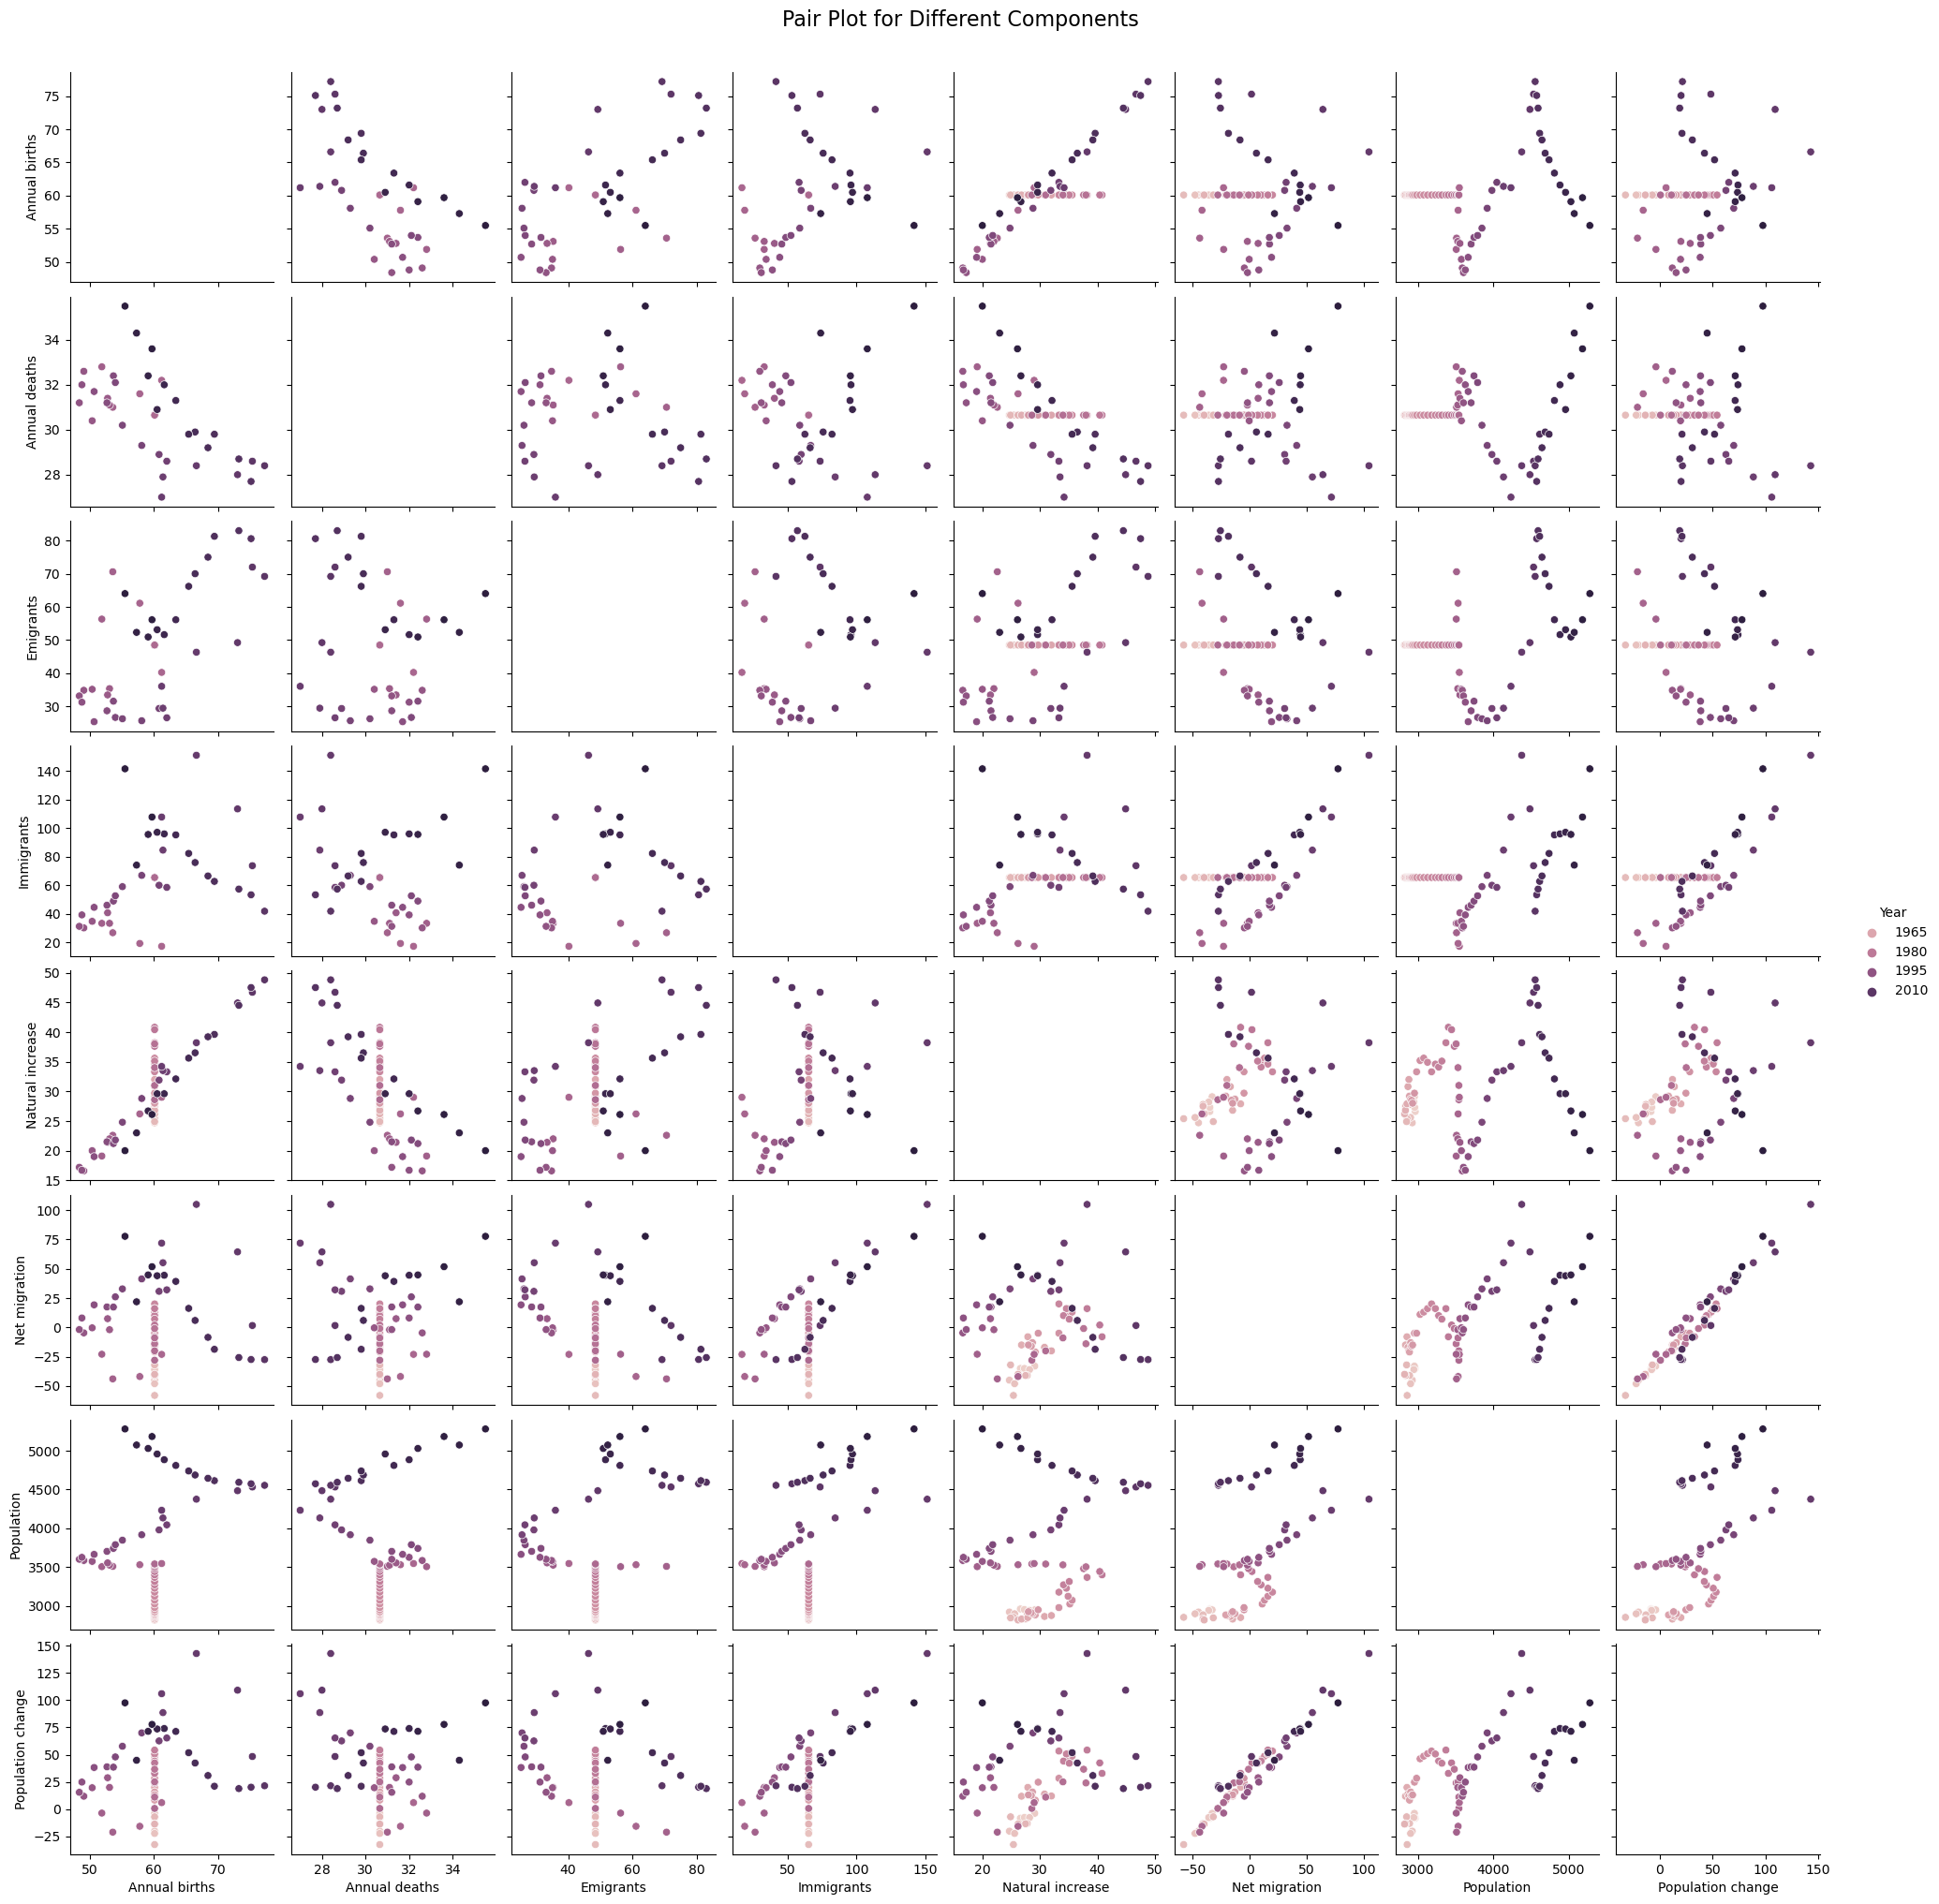

In [25]:
# Pair plot to visualize relationships between different variables
sns.pairplot(df_imputed, hue = 'Year', markers='o')
plt.suptitle('Pair Plot for Different Components', y=1.02, fontsize=16)
plt.savefig('pair_plot_components.png')
plt.show()

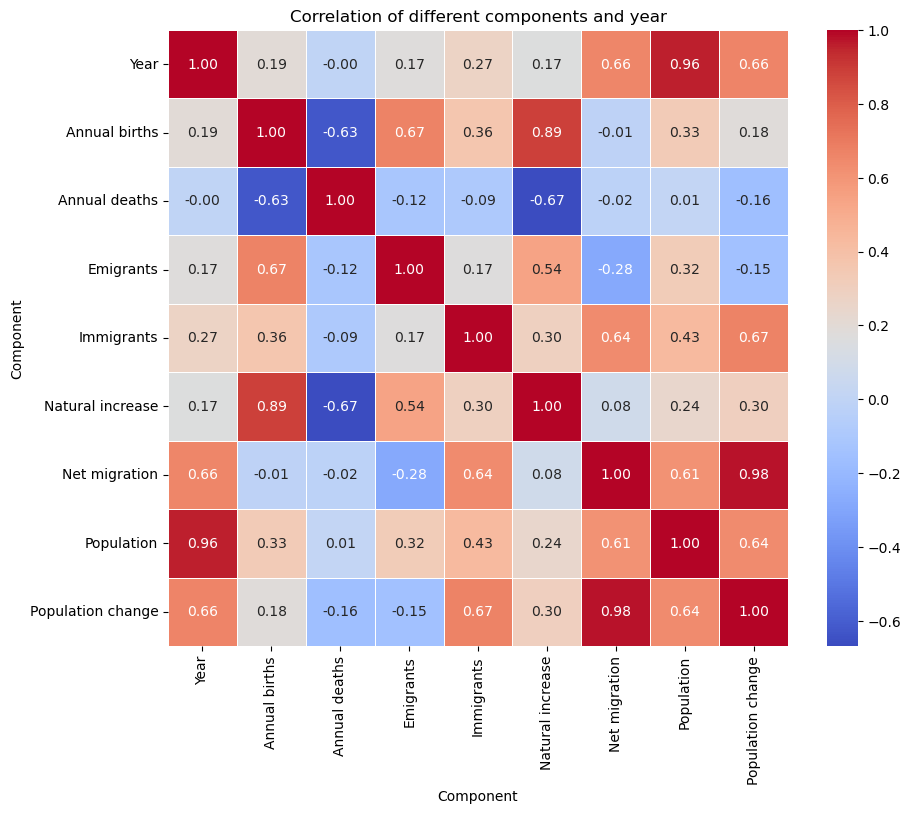

In [26]:
# creating a heatmap to find out the correlation between the different components
correlation_matrix = df_imputed.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation of different components and year')
plt.savefig('correlation_heatmap_components.png')
plt.show()

##### Population change vs Net Migration
- High positive correlation between population change and net migration.
- Indicates that changes in population are closely linked to migration patterns.
- When net migration increases (more people moving in than out), overall population change rises, and vice versa.
- Aligns with the common understanding that migration significantly influences population dynamics.

##### Annual Births and Natural Increase:
- High positive correlation between annual births and natural increase.
- Signifies that a significant portion of population growth is due to natural population growth (births minus deaths).
- Increase in annual births leads to higher natural increase, while a decrease in births results in lower natural increase.

##### Year and Population:
- High positive correlation between year and population.
- Suggests a trend of overall population growth over the years.
- Aligns with the expectation that populations generally increase over time due to factors like birth rates exceeding death rates, immigration, and other demographic factors.

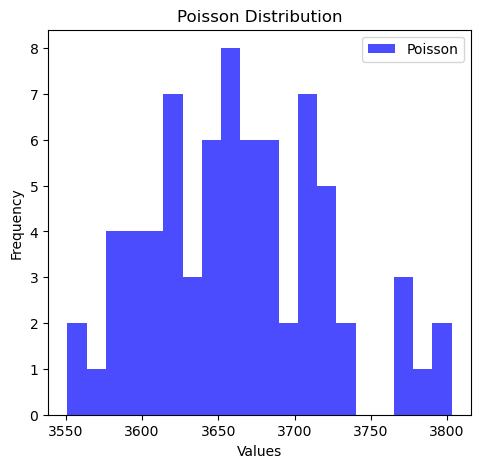

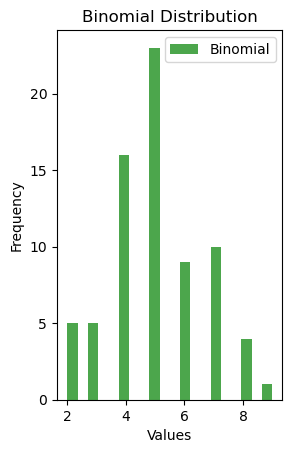

In [41]:
# Poisson Distribution
lambda_poisson = df_new['Population'].mean() # using the mean value of the population column as a poisson parameter
poisson_samples = np.random.poisson(lambda_poisson, size = len(df_new))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(poisson_samples, bins = 20, color = 'blue', alpha = 0.7, label = "Poisson")
plt.title('Poisson Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Poisson_distribution.png')
plt.show()

# Binomial Distribution
p_binomial = 0.5 
n_binomial = 10 
binomial_samples = np.random.binomial(n_binomial, p_binomial, size=len(df_new))


plt.subplot(1, 2, 2)
plt.hist(binomial_samples, bins=20, color='green', alpha=0.7, label='Binomial')
plt.title('Binomial Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Binomial_distribution.png')
plt.show()

## Machine Learning Model Training

In [27]:
X_null_zero = df_na_filled.drop(['Population'],axis=1)
y_null_zero = df_na_filled['Population']

In [28]:
X_na_mean = df_imputed.drop(['Population'],axis=1)
y_na_mean = df_imputed['Population']

In [29]:
# Creating training and testing sets of both the X and values
X_null_zero_train, X_null_zero_test, y_null_zero_train, y_null_zero_test = train_test_split(X_null_zero, y_null_zero, test_size=0.2, random_state=42)
X_na_mean_train, X_na_mean_test, y_na_mean_train, y_na_mean_test = train_test_split(X_na_mean, y_na_mean, test_size=0.2, random_state = 42)

In [30]:
# Scaling the values
scaler = StandardScaler()
X_null_zero_train_scaled = scaler.fit_transform(X_null_zero_train)
X_null_zero_test_scaled = scaler.fit_transform(X_null_zero_test)
X_na_mean_train_scaled = scaler.fit_transform(X_na_mean_train)
X_na_mean_test_scaled = scaler.fit_transform(X_na_mean_test)

In [32]:
# initilizing machine learning models
linear_reg = LinearRegression()
random_forest = RandomForestRegressor()
svm = SVR()

In [33]:
# creating a dictionary for models
models = {
    'Linear Regression': linear_reg,
    'Random Forest Regression': random_forest,
    'Support Vector Machine': svm
}

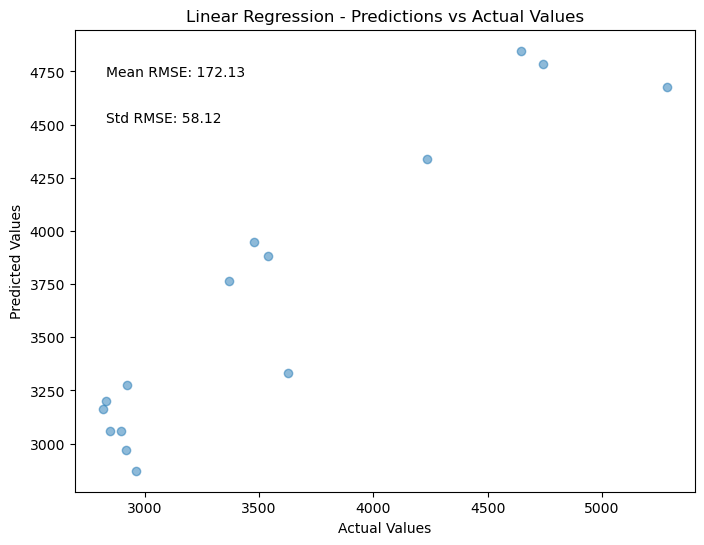

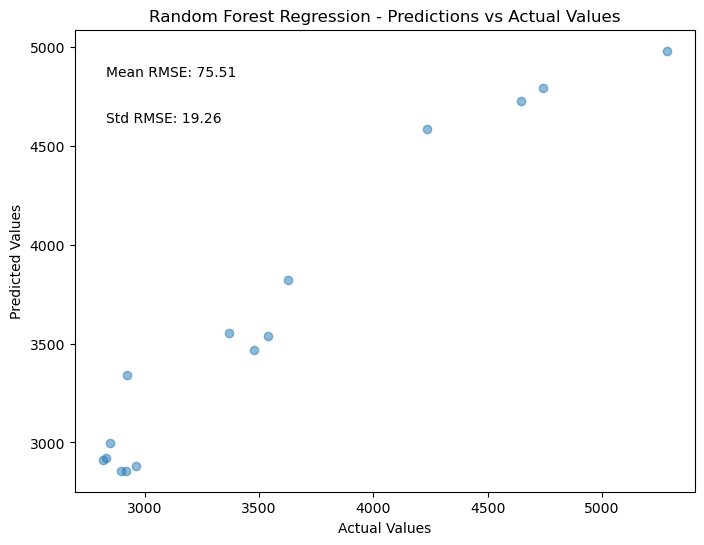

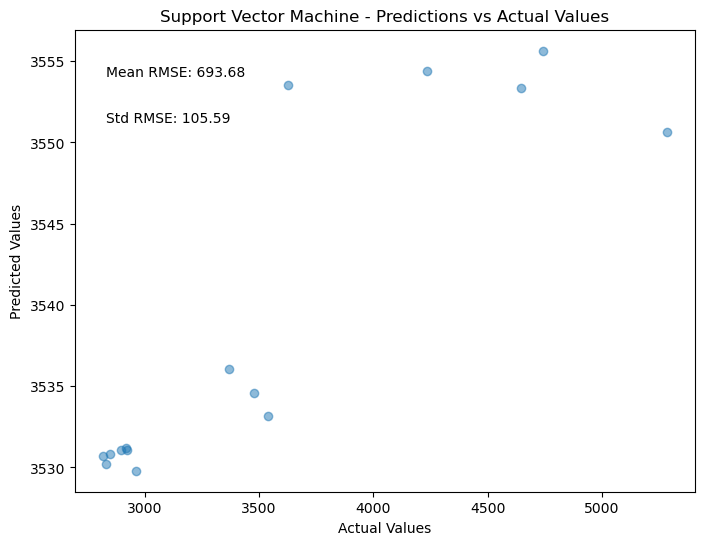

Best Model (Linear Regression) - Test MSE: 97256.64173083991, Test RMSE: 311.85997135066873


In [34]:
# applying the machine learning models to the training and testing data when null values are replaced with zeros
for model_name, model in models.items():
    mse_scores = -cross_val_score(model, X_null_zero_train_scaled, y_null_zero_train, cv = 5, scoring = 'neg_mean_squared_error')
    rmse_scores = mse_scores ** 0.5
    
    # plotting the predections actual values vs predicted values
    model.fit(X_null_zero_train_scaled, y_null_zero_train)
    y_pred = model.predict(X_null_zero_test_scaled)
    
    plt.figure(figsize=(8,6))
    plt.scatter(y_null_zero_test, y_pred, alpha=0.5)
    plt.title('{} - Predictions vs Actual Values'.format(model_name))
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    
    plt.text(0.05, 0.9, f'Mean RMSE: {rmse_scores.mean():.2f}', transform=plt.gca().transAxes)
    plt.text(0.05, 0.8, f'Std RMSE: {rmse_scores.std():.2f}', transform=plt.gca().transAxes)
    
    plt.savefig('{} - Predictions vs Actual Values'.format(model_name)+'.png')
    plt.show()
    


    
best_model_name = min(models, key = lambda x: mse_scores.mean())
best_model = models[best_model_name]

best_model.fit(X_null_zero_train_scaled, y_null_zero_train)

y_pred_best = best_model.predict(X_null_zero_test_scaled)
test_mse = mean_squared_error(y_null_zero_test, y_pred_best)
test_rmse = mean_squared_error(y_null_zero_test, y_pred_best, squared=False)
print("Best Model ({}) - Test MSE: {}, Test RMSE: {}".format(best_model_name,test_mse,test_rmse))

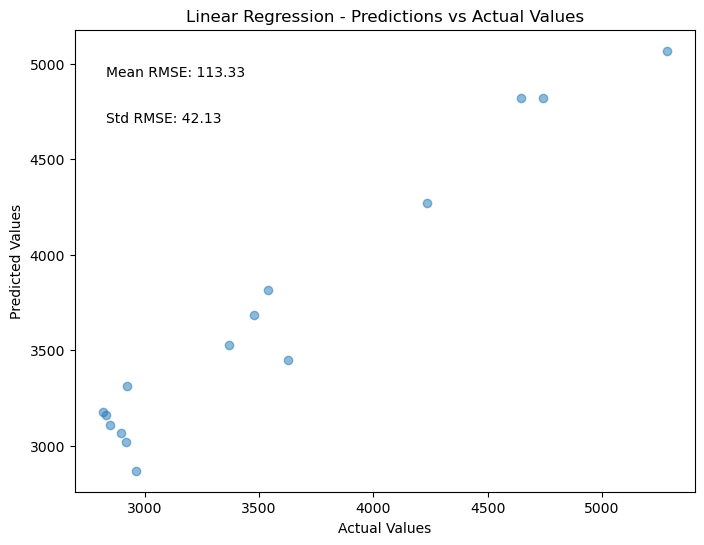

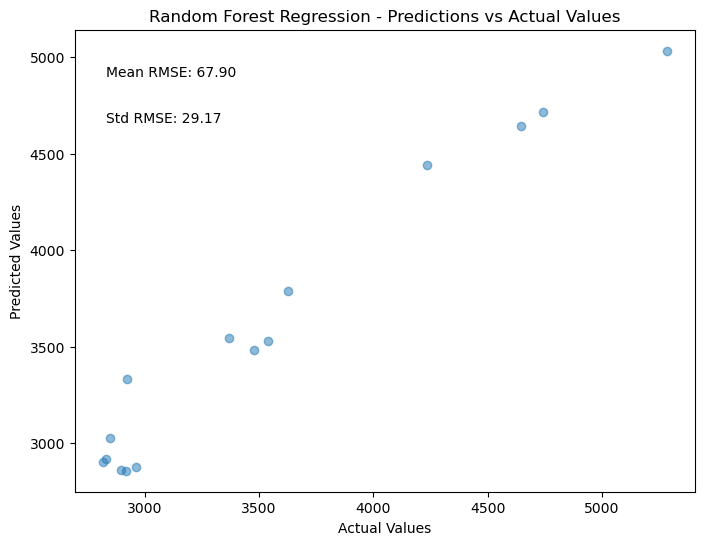

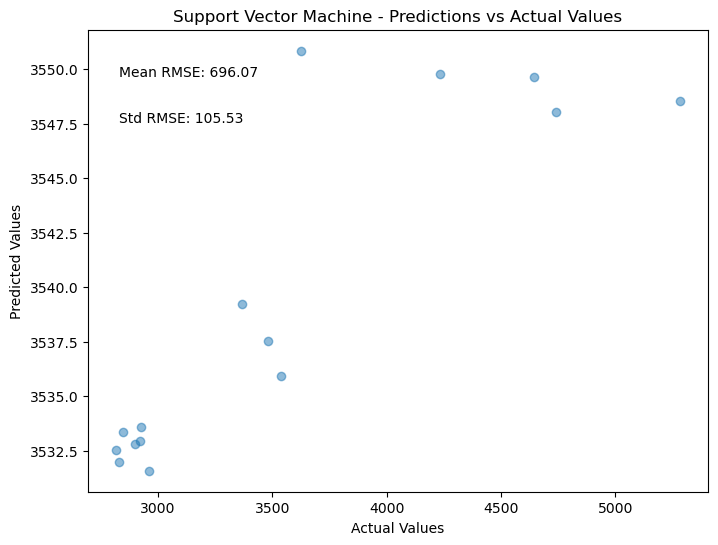

Best Model (Linear Regression) - Test MSE: 51061.89152688782, Test RMSE: 225.96878440812975


In [35]:
# applying the machine learning models to the training and testing data when null values are replaced with mean
for model_name, model in models.items():
    mse_scores = -cross_val_score(model, X_na_mean_train_scaled, y_na_mean_train, cv = 5, scoring = 'neg_mean_squared_error')
    rmse_scores = mse_scores ** 0.5
    
    # plotting the predections actual values vs predicted values
    model.fit(X_na_mean_train_scaled, y_na_mean_train)
    y_pred = model.predict(X_na_mean_test_scaled)
    
    plt.figure(figsize=(8,6))
    plt.scatter(y_na_mean_test, y_pred, alpha=0.5)
    plt.title('{} - Predictions vs Actual Values'.format(model_name))
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    
    plt.text(0.05, 0.9, f'Mean RMSE: {rmse_scores.mean():.2f}', transform=plt.gca().transAxes)
    plt.text(0.05, 0.8, f'Std RMSE: {rmse_scores.std():.2f}', transform=plt.gca().transAxes)
    
    plt.savefig('{} - Predictions vs Actual Values'.format(model_name)+'.png')
    plt.show()
    


    
best_model_name = min(models, key = lambda x: mse_scores.mean())
best_model = models[best_model_name]

best_model.fit(X_na_mean_train_scaled, y_na_mean_train)

y_pred_best = best_model.predict(X_na_mean_test_scaled)
test_mse = mean_squared_error(y_na_mean_test, y_pred_best)
test_rmse = mean_squared_error(y_na_mean_test, y_pred_best, squared=False)
print("Best Model ({}) - Test MSE: {}, Test RMSE: {}".format(best_model_name,test_mse,test_rmse))

In the context of machine learning, the primary objective is typically to minimise error metrics, such as MSE and RMSE. The lower the values of MSE and RMSE, the better the predictive performance of the model.
Upon comparing the results of two approaches for handling null values:

- Replacing Null Values with Zeros:
    * Test MSE: 97256.64173083991
    * Test RMSE: 311.85997135066873
- Replacing Null Values with Mean Values:
    * Test MSE: 51061.89152688782
    * Test RMSE: 225.96878440812975

It is evident that the model employing the technique of replacing null values with mean values outperforms the one replacing null values with zeros. This is evidenced by the lower MSE and RMSE, indicating that the predictions align more closely with the actual values.

Consequently, opting for the strategy of replacing null values with mean values appears to be the more effective approach for enhancing the performance of your linear regression model."